## TODO
- kako hendlati da 1 sat ocitanja ima isti timeseries (izbrisi jedan sat duplikanata, realno mislim da neces tu nista izgubiti)
- Napraviti modele za neki parametar (baseline)
- Izbaciti outliere za neki parametar i ponoviti treniranje (boxplot)
- normalizirati data (zato sto je door opened od 0-1 a parametri vise od tog lol) - provjeri je li ovo potrebno
- Nekako preppati training data, mozda napraviti derivaciju training date i vidjeti je li model bolji
- Nalaskom najboljeg rezultata za jedan parametar, (uzmi onaj sa najvecom korelacijom u korelacijskoj matrici i sa plottova) to ponovi i za sve ostale parametre
- DOLJE TODOs SU ZA MODEL KOJI KOMBINIRA PARAMETRE KAKO BI NAPRAVIO PREDICTION
- Feature selection kao kombinacija parametara
- https://hal.science/hal-04432021v1/document, feature selection
- "Except for RFC models, features are normalized between 0 and	1 based	on the training	set	characteristics"

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import seaborn as sns
import json

### DATA LOADING AND PREPROCESSING

In [ ]:
# Load and preprocess door and window data
door_df = pd.read_csv('datasets/Door_windows.csv')
door_df = door_df.drop('Door_balcony_1st_floor', axis=1)
door_df = door_df.drop_duplicates(subset='Date')
door_df['Date'] = pd.to_datetime(door_df['Date'], format='%d/%m/%Y %H:%M')
door_df = door_df.sort_values('Date')

door_df['Door_Garden'] = door_df['Door_Garden'].map({'on': 1, 'off': 0})
door_df['Door_Hallway'] = door_df['Door_Hallway'].map({'on': 1, 'off': 0})

# Create a new dataframe with 1-second intervals
start_time = door_df['Date'].min()
end_time = door_df['Date'].max()
time_range = pd.date_range(start=start_time, end=end_time, freq='1S')
door_df_1s = pd.DataFrame({'Date': time_range})

# Merge with the original dataframe to fill in missing rows
door_df_1s = pd.merge(door_df_1s, door_df, on='Date', how='left')

# Fill missing values based on the last known status
door_df_1s['Door_Garden'] = door_df_1s['Door_Garden'].fillna(method='ffill')
door_df_1s['Door_Hallway'] = door_df_1s['Door_Hallway'].fillna(method='ffill')
    
# Create a binary state for any door being open
door_df_1s["any_door_open"] = ((door_df_1s["Door_Garden"] == 1) | (door_df_1s["Door_Hallway"] == 1)).astype(int)
door_df_1s['Date'] = pd.to_datetime(door_df_1s['Date'], format='%d/%m/%Y %H:%M')
#door_df_1s.to_csv("datasets/door_windows_combined.csv", index=False)

sensor_df = pd.read_csv('datasets/LS0623020168.csv')
# Convert UTC to UTC+2
sensor_df['timestamp(ZG)'] = pd.to_datetime(sensor_df['timestamp(UTC)']) + timedelta(hours=2)

# Handling daylight savings (UTC+1)
dst_cutoff = pd.Timestamp('2024-10-27 03:00:00')
sensor_df['timestamp(ZG)'] = sensor_df['timestamp(ZG)'].apply(
    lambda x: x - timedelta(hours=1) if x >= dst_cutoff else x
)

merged_df = pd.merge(sensor_df, door_df_1s[["Date", "Door_Garden", "Door_Hallway", "any_door_open"]],
                     left_on="timestamp(ZG)", right_on="Date", how="left")
merged_df = merged_df.drop(columns=["Date"])
merged_df = merged_df[merged_df["timestamp(ZG)"] >= start_time]

# Dropping duplicated values of timestamp resulted in moving the clock by 1 hour
merged_df = merged_df.drop_duplicates(subset='timestamp(ZG)', keep='first')

#merged_df.to_csv("datasets/merged_sensor_data.csv", index=False)

### Filtering out times of experiments being done

In [117]:
with open("datasets/experiments.json", "r") as file:
    experiment_data = json.load(file)

# Convert the experiment intervals into a DataFrame
intervals = []
for experiment, times in experiment_data["experiments"].items():
    for time_range in times:
        intervals.append({"start": pd.to_datetime(time_range[0]), "end": pd.to_datetime(time_range[1])})

intervals_df = pd.DataFrame(intervals)

# Filter out rows within the intervals
for _, row in intervals_df.iterrows():
    merged_df = merged_df[
        ~((merged_df['timestamp(ZG)'] >= row['start']) & (merged_df['timestamp(ZG)'] <= row['end']))
    ]

#merged_df.to_csv("datasets/merged_sensor_data_no_experiments.csv", index=False)

### Visualizing the data

In [118]:
# Visualizing the whole dataset
"""
# Set up a figure for the subplots
fig, axs = plt.subplots(8, 2, figsize=(15, 30))
fig.suptitle('Time series of paramaters', fontsize=16)

# List of parameters and titles
parameters = [
    ('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    ('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    ('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    ('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

# Plot each parameter in a separate subplot
for i, (param, title) in enumerate(parameters):
    row, col = divmod(i, 2)
    axs[row, col].plot(sensor_df['timestamp(ZG)'], sensor_df[param])
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(title)
    axs[row, col].tick_params(axis='x', rotation=45)

axs[7,1].plot(merged_df['timestamp(ZG)'],merged_df['any_door_open'])
axs[7,1].set_title('Any door open')
axs[7,1].set_xlabel('Time')
axs[7,1].set_ylabel('Yes (1), No (0)')
axs[7,1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()
"""

"\n# Set up a figure for the subplots\nfig, axs = plt.subplots(8, 2, figsize=(15, 30))\nfig.suptitle('Time series of paramaters', fontsize=16)\n\n# List of parameters and titles\nparameters = [\n    ('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),\n    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),\n    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),\n    ('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),\n    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),\n    ('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),\n    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),\n    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),\n    ('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),\n    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),\n    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),\n    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),\n    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),\n    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),\n    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')\n]\n\n# Plot each parameter in a separate s

### For visualizing door opening, the data is reduced from 5s to 1m readings, the sensor data is the average value in that 1 minute, each day is saved as image in daily_plots

In [119]:
# Generating images by days
"""
import os

parameters = [
    #('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    #('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    #('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    #('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

# Set the UTC+1 timestamp as the index
merged_df.set_index('timestamp(ZG)', inplace=True)

# Resample the data to 1-minute intervals and calculate the mean
data_resampled = merged_df.resample('1T').mean()

# Reset the index to make 'timestamp(ZG)' a column again
data_resampled = data_resampled.reset_index()

# Ensure the directory for saving plots exists
output_dir = "daily_plots2"
os.makedirs(output_dir, exist_ok=True)

# Loop through each unique day in the dataset
data_resampled['date'] = data_resampled['timestamp(ZG)'].dt.date
unique_days = data_resampled['date'].unique()

for day in unique_days:
    # Filter data for the specific day
    day_data = data_resampled[data_resampled['date'] == day]
    open_door_times = day_data[day_data['any_door_open'] == 1]['timestamp(ZG)']
    
    # Set up a figure for the subplots
    fig, axs = plt.subplots(8, 2, figsize=(15, 30))
    fig.suptitle(
        f'Time series of parameters for {day}, red line = garden door open, blue line = hallway door open', 
        fontsize=16
    )
    
    # Plot each parameter in a separate subplot
    for i, (param, title) in enumerate(parameters):
        row, col = divmod(i, 2)
        axs[row, col].plot(day_data['timestamp(ZG)'], day_data[param])
        axs[row, col].set_title(title)
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel(title)
        axs[row, col].tick_params(axis='x', rotation=45)
        
        # Add vertical lines for door open times with color
        for open_time in open_door_times:
            open_time_door_data = day_data[day_data['timestamp(ZG)'] == open_time]
            if (open_time_door_data['Door_Garden'].values == 1):
                axs[row, col].axvline(x=open_time, color='red', linestyle='--', lw=1, alpha=0.1)
            if (open_time_door_data['Door_Hallway'].values == 1):
                axs[row, col].axvline(x=open_time, color='blue', linestyle='--', lw=1, alpha=0.1)
    
    # Remove unused subplots if they exist
    for j in range(len(parameters), len(axs.flatten())):
        fig.delaxes(axs.flatten()[j])
    
    # Adjust layout and save the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.savefig(os.path.join(output_dir, f'{day}.png'))
    plt.close(fig)
"""

'\nimport os\n\nparameters = [\n    #(\'NetCO2-CO2(ppm)\', \'NetCO2-CO2 (ppm)\'),\n    (\'NetCO2-CO2_ug\', \'NetCO2-CO2 (µg)\'),\n    (\'NetADC_O3-O3_ug\', \'NetADC_O3-O3 (µg)\'),\n    #(\'NetADC_O3-O3(ppb)\', \'NetADC_O3-O3 (ppb)\'),\n    (\'NetADC_CO-CO_ug\', \'NetADC_CO-CO (µg)\'),\n    #(\'NetADC_CO-CO( ppb)\', \'NetADC_CO-CO (ppb)\'),\n    (\'NetPM-PM10(µg/m3)\', \'NetPM-PM10 (µg/m³)\'),\n    (\'NetPM-PM25(µg/m3)\', \'NetPM-PM25 (µg/m³)\'),\n    #(\'NetPid_P1-PPB(ppm)\', \'NetPid_P1-PPB (ppm)\'),\n    (\'NetPid_P1-PPB_ug\', \'NetPid_P1-PPB (µg)\'),\n    (\'NetBME280-PERC(%)\', \'NetBME280 Humidity (%)\'),\n    (\'NetBME280-TEMP_EXT(°C)\', \'NetBME280 Temperature (°C)\'),\n    (\'NetBME280-HPA(hPa)\', \'NetBME280 Pressure (hPa)\'),\n    (\'NetADC_NO2-NO2_ug\', \'NetADC_NO2-NO2 (µg)\'),\n    (\'NetADC_NO2-NO2(ppb)\', \'NetADC_NO2-NO2 (ppb)\')\n]\n\n# Set the UTC+1 timestamp as the index\nmerged_df.set_index(\'timestamp(ZG)\', inplace=True)\n\n# Resample the data to 1-minute interval

In [120]:
# Code for plotting current days
"""
#20-21 3 min generiranje, u 11.2 sekunde
start_time = '2024-10-29'  
end_time = '2024-10-30'

merged_df.set_index('timestamp(ZG)', inplace=True)
data_resampled = merged_df.resample('1T').mean()
data_resampled = data_resampled.reset_index()

filtered_resampled_df = data_resampled[(data_resampled['timestamp(ZG)'] >= start_time) & (data_resampled['timestamp(ZG)'] <= end_time)]

# Set up a figure for the subplots
fig, axs = plt.subplots(8, 2, figsize=(15, 30))
fig.suptitle('Time series of parameters smaller interval, red line = garden door open, blue line = hallway door open', fontsize=16)

# List of parameters and titles
parameters = [
    #('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    #('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    #('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    #('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    #('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

open_door_times = filtered_resampled_df[filtered_resampled_df['any_door_open'] == 1]['timestamp(ZG)']

# Plot each parameter in a separate subplot
for i, (param, title) in enumerate(parameters):
    row, col = divmod(i, 2)
    axs[row, col].plot(filtered_resampled_df['timestamp(ZG)'], filtered_resampled_df[param])
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(title)
    axs[row, col].tick_params(axis='x', rotation=45)

    # Add vertical lines for door open times with color
    for open_time in open_door_times:
        open_time_door_data = filtered_resampled_df[filtered_resampled_df['timestamp(ZG)'] == open_time]
        if (open_time_door_data['Door_Garden'].values == 1):
            axs[row, col].axvline(x=open_time, color='red', linestyle='--', lw=1, alpha=0.1)
        if (open_time_door_data['Door_Hallway'].values == 1):
            axs[row, col].axvline(x=open_time, color='blue', linestyle='--', lw=1, alpha=0.1)

# Remove unused subplots if they exist
for j in range(len(parameters), len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()
"""


"\n#20-21 3 min generiranje, u 11.2 sekunde\nstart_time = '2024-10-29'  \nend_time = '2024-10-30'\n\nmerged_df.set_index('timestamp(ZG)', inplace=True)\ndata_resampled = merged_df.resample('1T').mean()\ndata_resampled = data_resampled.reset_index()\n\nfiltered_resampled_df = data_resampled[(data_resampled['timestamp(ZG)'] >= start_time) & (data_resampled['timestamp(ZG)'] <= end_time)]\n\n# Set up a figure for the subplots\nfig, axs = plt.subplots(8, 2, figsize=(15, 30))\nfig.suptitle('Time series of parameters smaller interval, red line = garden door open, blue line = hallway door open', fontsize=16)\n\n# List of parameters and titles\nparameters = [\n    #('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),\n    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),\n    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),\n    #('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),\n    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),\n    #('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),\n    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),\n   

#### We can see that although the correlation matrix doesn't give the best correlations results there is a clear correlation in the plots between rapid change of co2, 03, co etc. parameters and the door being opened. 
#### Thesis: using derivations (amount of change through time) to predict when the doors are opened. In other words, the doors are definitely opened when there is a bigger change in paramaters. Another thing to note is that we should try other ways of prepping the training data, other than putting it straight in.

### Analysis of data

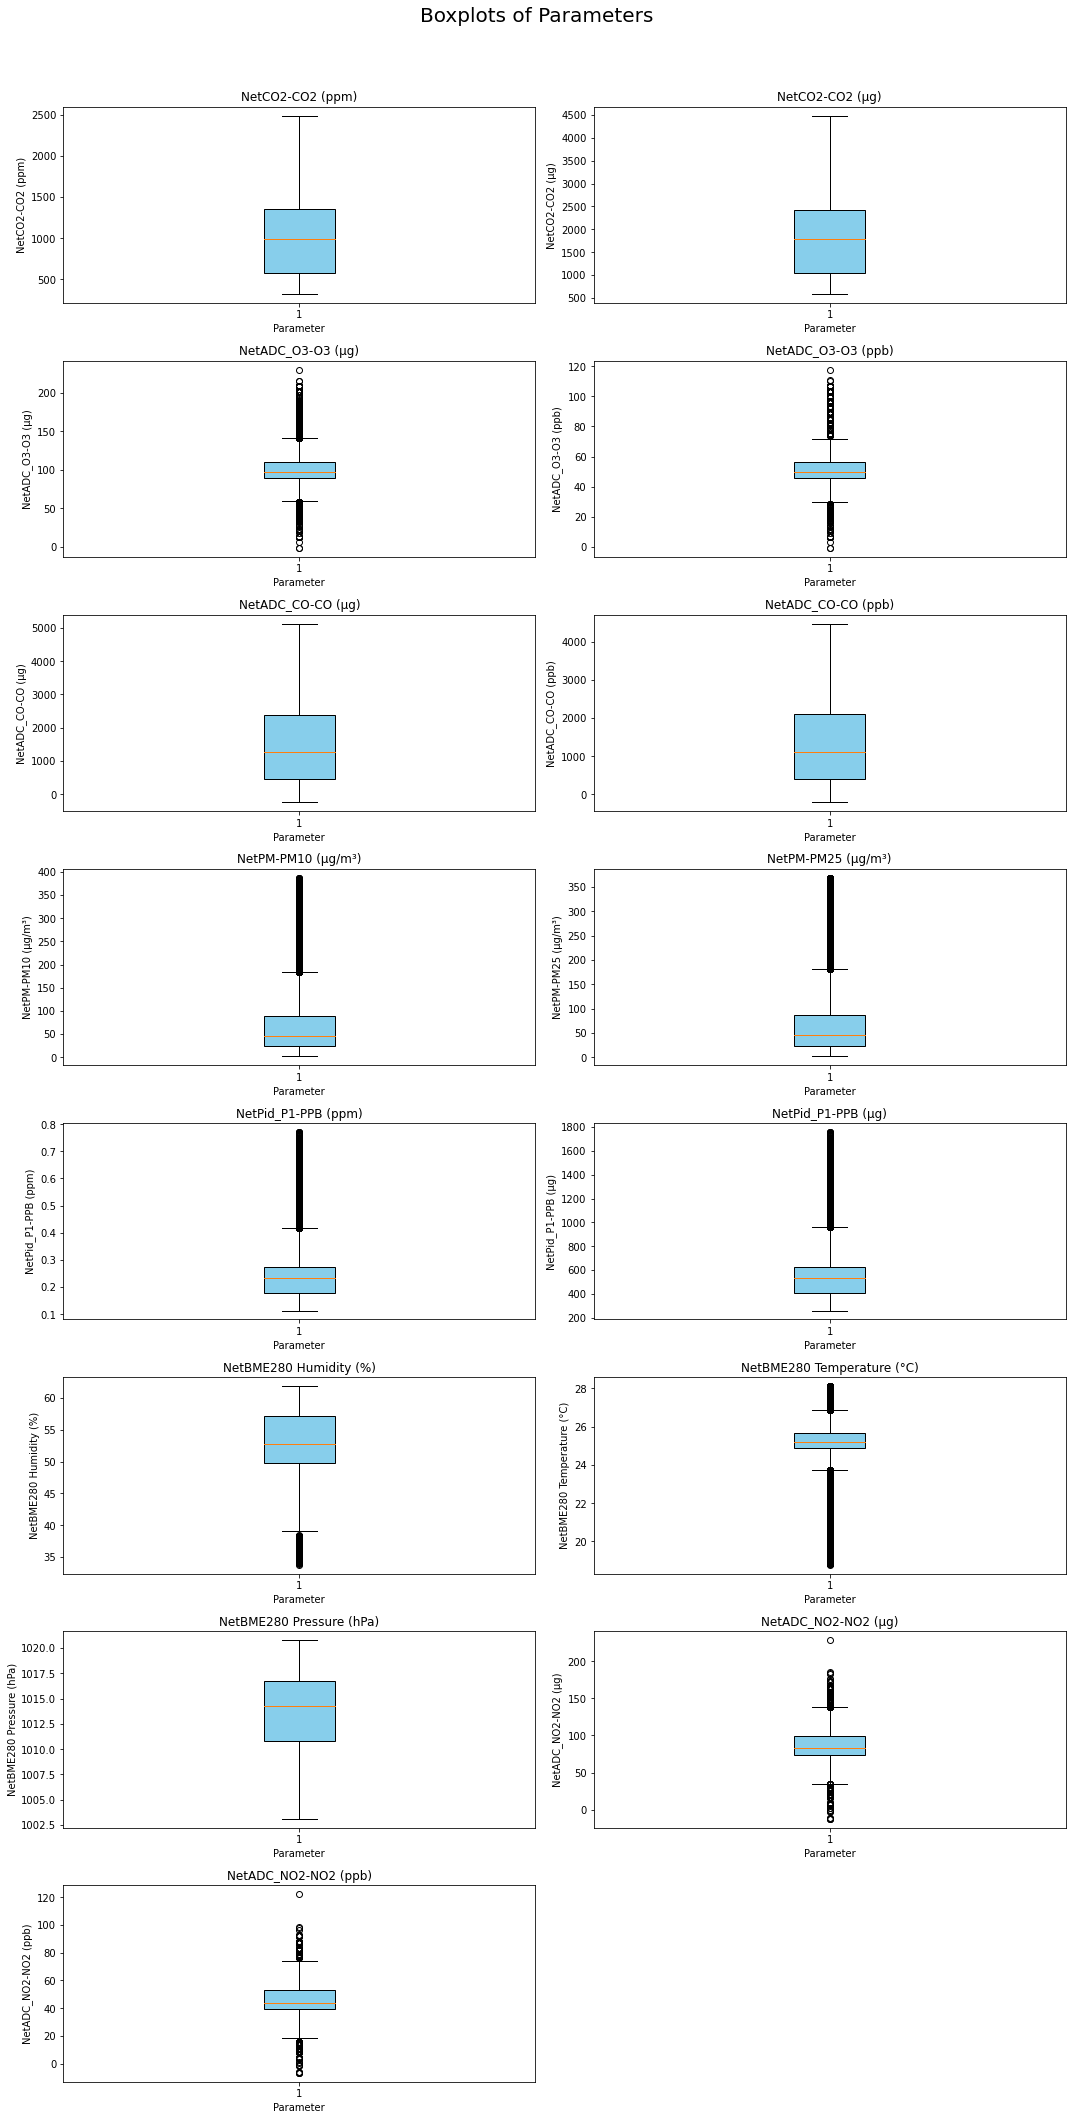

In [121]:
import matplotlib.pyplot as plt

# Set up a figure for the subplots
fig, axs = plt.subplots(8, 2, figsize=(15, 30))
fig.suptitle('Boxplots of Parameters', fontsize=20)

# List of parameters and titles
parameters = [
    ('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    ('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    ('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    ('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

# Plot each parameter in a separate subplot as a boxplot
for i, (param, title) in enumerate(parameters):
    row, col = divmod(i, 2)
    box = axs[row, col].boxplot(merged_df[param].dropna(),
                                patch_artist=True,  # Enables coloring
                                boxprops=dict(facecolor='skyblue', color='black'))
    axs[row, col].set_title(title, fontsize=12)
    axs[row, col].set_xlabel('Parameter')
    axs[row, col].set_ylabel(title)

for j in range(len(parameters), len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()


### Correlation matrix, removed ppm/ug readings where applicable, with outliers

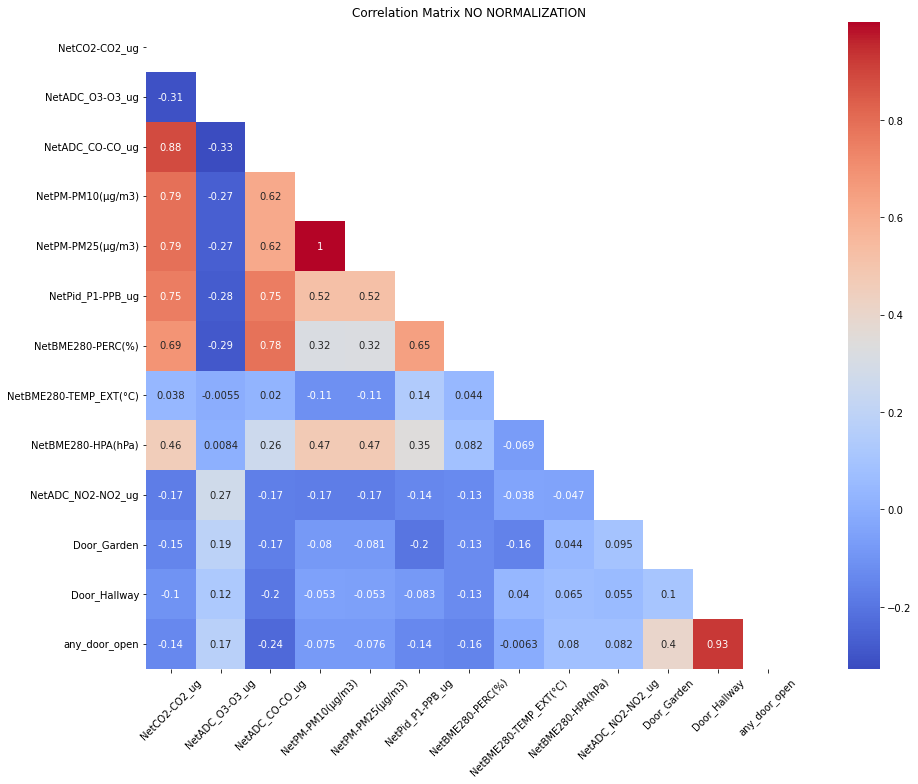

In [122]:
columns_to_consider = [
    'NetCO2-CO2_ug', 'NetADC_O3-O3_ug','NetADC_CO-CO_ug', 'NetPM-PM10(µg/m3)', 
    'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB_ug', 'NetBME280-PERC(%)', 'NetBME280-TEMP_EXT(°C)',
    'NetBME280-HPA(hPa)', 'NetADC_NO2-NO2_ug', 'Door_Garden', 
    'Door_Hallway', 'any_door_open'
]

# Subset the dataframe to include only the desired columns
df_subset = merged_df[columns_to_consider]

# Compute the correlation matrix
correlation_matrix = df_subset.corr()

# Plot the heatmap using seaborn
plt.figure(figsize=(16, 11))
#sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), square=True)

# Display the plot
plt.title('Correlation Matrix NO NORMALIZATION')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Correlation matrix with normalized data the same as the corr. matrix with not normalized data

In [123]:
# Normaliziranje podataka te crtanje korelacijske matrice
"""
from sklearn.preprocessing import MinMaxScaler

parameters_to_normalize = [
    'NetCO2-CO2(ppm)', 'NetCO2-CO2_ug', 'NetADC_O3-O3_ug',
    'NetADC_O3-O3(ppb)', 'NetADC_CO-CO_ug', 'NetADC_CO-CO( ppb)',
    'NetPM-PM10(µg/m3)', 'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB(ppm)',
    'NetPid_P1-PPB_ug', 'NetBME280-PERC(%)', 'NetBME280-TEMP_EXT(°C)',
    'NetBME280-HPA(hPa)', 'NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2(ppb)',
    'Door_Garden', 'Door_Hallway', 'any_door_open'
]

# Normalize the data
scaler = MinMaxScaler()  # Use StandardScaler() for Z-score normalization
sensor_df_normalized = merged_df.copy()
sensor_df_normalized[parameters_to_normalize] = scaler.fit_transform(merged_df[parameters_to_normalize])

# Set up a figure for the subplots
fig, axs = plt.subplots(8, 2, figsize=(15, 30))
fig.suptitle('Boxplots of Parameters', fontsize=20)

# List of parameters and titles
parameters = [
    ('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    ('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    ('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    ('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)'),
    ('Door_Garden', 'Door_Garden')
]

# Plot each parameter in a separate subplot as a boxplot
for i, (param, title) in enumerate(parameters):
    row, col = divmod(i, 2)
    box = axs[row, col].boxplot(sensor_df_normalized[param].dropna(),
                                patch_artist=True,  # Enables coloring
                                boxprops=dict(facecolor='skyblue', color='black'))
    axs[row, col].set_title(title, fontsize=12)
    axs[row, col].set_xlabel('Parameter')
    axs[row, col].set_ylabel(title)

for j in range(len(parameters), len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()

# Generate correlation matrix
correlation_matrix = sensor_df_normalized[parameters_to_normalize].corr()

# Plot the correlation matrix
plt.figure(figsize=(16, 11))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), square=True)
plt.title("Correlation Matrix WITH NORMALIZATION", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
"""

'\nfrom sklearn.preprocessing import MinMaxScaler\n\nparameters_to_normalize = [\n    \'NetCO2-CO2(ppm)\', \'NetCO2-CO2_ug\', \'NetADC_O3-O3_ug\',\n    \'NetADC_O3-O3(ppb)\', \'NetADC_CO-CO_ug\', \'NetADC_CO-CO( ppb)\',\n    \'NetPM-PM10(µg/m3)\', \'NetPM-PM25(µg/m3)\', \'NetPid_P1-PPB(ppm)\',\n    \'NetPid_P1-PPB_ug\', \'NetBME280-PERC(%)\', \'NetBME280-TEMP_EXT(°C)\',\n    \'NetBME280-HPA(hPa)\', \'NetADC_NO2-NO2_ug\', \'NetADC_NO2-NO2(ppb)\',\n    \'Door_Garden\', \'Door_Hallway\', \'any_door_open\'\n]\n\n# Normalize the data\nscaler = MinMaxScaler()  # Use StandardScaler() for Z-score normalization\nsensor_df_normalized = merged_df.copy()\nsensor_df_normalized[parameters_to_normalize] = scaler.fit_transform(merged_df[parameters_to_normalize])\n\n# Set up a figure for the subplots\nfig, axs = plt.subplots(8, 2, figsize=(15, 30))\nfig.suptitle(\'Boxplots of Parameters\', fontsize=20)\n\n# List of parameters and titles\nparameters = [\n    (\'NetCO2-CO2(ppm)\', \'NetCO2-CO2 (ppm)\'),\